# Final Project B

## Basic stats. Let's understand the dataset better
We start of by cleaning and preparing our data which consists of over 1.67M rows with a total of 29 columns.


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
df_crash = pd.read_csv("C:\\Users\Dude\Desktop\Vision Zero\Motor_Vehicle_Collisions_-_Crashes.csv", low_memory = False)

#Formatting date and time
df_crash["CRASH DATE"] = df_crash["CRASH DATE"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y") )
df_crash["CRASH TIME"] = df_crash["CRASH TIME"].apply(lambda x: datetime.strptime(x, "%H:%M") )

### Time-series
As we're dealing with data that ranges from mid 2012 to now, we want to make sure that there aren't any missing gaps throughout this period of time.

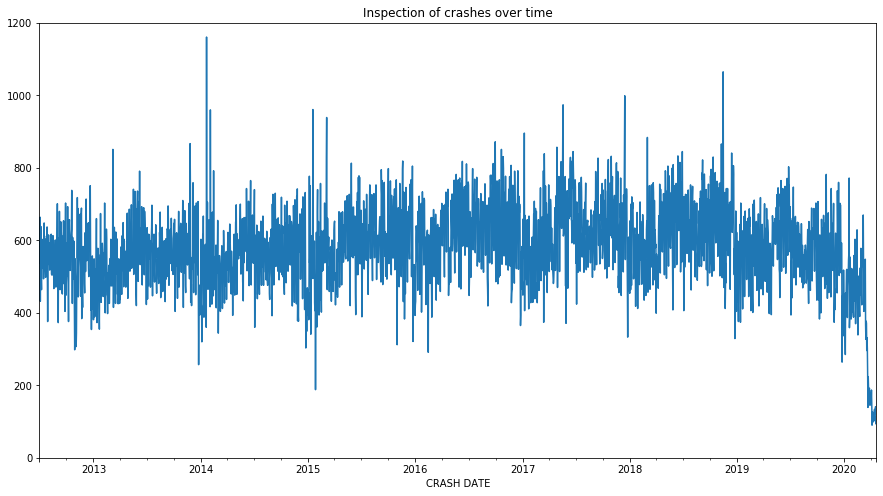

In [10]:
#Checking the range of our data
df_crash.groupby('CRASH DATE').size().plot(figsize=(15,8),ylim = (0,1200), title = "Inspection of crashes over time" )

There appear to be no gaps (missing periods) from mid 2012 to 2020. But since we will be taking a look at the change of crashes from year to year, we will limit our data to consist of only dates ranging from 2013 to 2019. 

In [11]:
df_crash = df_crash.loc[((df_crash['CRASH DATE'].dt.year !=2020) & (df_crash['CRASH DATE'].dt.year != 2012))]

## Filling out missing values

A large part of our data was missing information about which borough the crash took place in. This information is however obtainable by looking up the coordinates, if given. To do this, we made use of the package 'geopy' and withdrew as many zip codes as we could, followed by merging them with a list of all zip codes and their respective borough.

Almost 320,000 rows were missing information about the Borough, while both latitude and longitude were present.

In [12]:
df_crash.loc[(df_crash['BOROUGH'].isna() & (df_crash['LATITUDE'].notna() & df_crash['LONGITUDE'].notna()))].shape

(318827, 29)

**Warning**! The following code is looking up each unique pair of coordinates and takes approximately 6 hours.

In [ ]:
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt

df_latlong = df_crash.loc[(df_crash['LATITUDE'].notna() & df_crash['LONGITUDE'].notna())].copy()
df_latlong['latlong'] = list(zip(df_latlong['LATITUDE'],df_latlong['LONGITUDE']))
locator = Nominatim(user_agent='myGeocoder', timeout= 50000)
dict_geocode = {}
address = df_latlong['latlong'].unique()
for x in address:
    if x not in dict_geocode:
        dict_geocode[x] = []
    location = locator.reverse(x)
    if 'address' in location.raw:
        if 'postcode' in location.raw['address']:
            dict_geocode[x].append(location.raw['address']['postcode'])

df_crash['address'] = list(zip(df_crash['LATITUDE'],df_crash['LONGITUDE']))
df_crash['postcode'] = df_crash['address'].map(dict_geocode)

df_zipcode = pd.read_csv("C:\\Users\Dude\Desktop\zip_codes2.csv")
df_zipcode['postcode'] = df_zipcode['postcode'].astype('str')

dict_zipcode = df_zipcode.set_index('postcode')['borough']
df_crash['district']=df_crash['postcode'].map(dict_zipcode)
df_crash['district']=df_crash['district'].str.upper()

#Replacing missing values in 'Borough' with the ones we've just retrived.
df_crash['BOROUGH'].loc[(df_crash['BOROUGH'].isna() & df_crash['district'].notna())] = df_crash['district']

#Saving our new dataset - to prevent running above code again.
df_crash.to_csv(r'C:\\Users\Dude\Desktop\crash_data.csv', index=False)

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
# We then have our new dataset - which we load again to refrain from running above code
df_crash = pd.read_csv("C:\\Users\Rimmen\crash_data.csv",low_memory=False)
df_crash["CRASH DATE"] = df_crash["CRASH DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_crash["CRASH TIME"] = df_crash["CRASH TIME"].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))

And that is about it. We made sure that there were no gaps from 2013 to 2019, and filled out over 300,000 missing values for 'Borough' to get the most out of our analysis. There are still many things to consider each time we include a variable, but in each scenario throughout this project, we accommodate our needs for that exact analysis, weather removing missing values or taking them into account.

## Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

- Await exploratory analysis


## Machine learning

Through machine learning, we wanted to see if the implmentation of different initiatives would have any impact on the contributing factors of a crash. However, the implementations for Vision Zero are plenty, and it would be hard to distinguish one from another. We therefore chose to single out an initiative, that we believe would have an high impact on certain contributing factors for a crash. Reduction of speed. 

In the late 2014, New York City reduced the default speed limit to 25 MPH, and installed multiple speed cameras and speed bumps. ([Automated Speed Enforcement Program Report, 2014-2017](http://www.nyc.gov/html/dot/downloads/pdf/speed-camera-report-june2018.pdf)) We believe that the reduction of speed would have a high impact on crashes caused by a slippery pavement, while crashes caused by alcohol involvement would be unaffected. 

This assumption is corresponding with our analysis on frequency of contributing factors from year to year. 
#### **INSERT PLOT**


By using the Random Forest Classifier model, we want to label the contributing factor of a crash, given a time (hour), location (borough) and information on whether the 'reduction of speed' had taken place or not.
We will use one hot encoding on the category 'Borough', to prevent our model from assuming any order between the 5 boroughs.

After implementing one hot encoding on 'borough', and assigning a value for '25mph' we end with the following dataframe consisting of 26687 rows.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler

ML= df_crash[['CRASH DATE','CRASH TIME','BOROUGH','CONTRIBUTING FACTOR VEHICLE 1']]
ML2 = ML.loc[ML['CONTRIBUTING FACTOR VEHICLE 1'].isin(['Alcohol Involvement','Pavement Slippery'])].copy()
ML2['CRASH DATE'] = ML2['CRASH DATE'].dt.year
ML2['CRASH TIME'] = ML2['CRASH TIME'].dt.hour
ML2['25mph'] = 0
ML2.loc[(ML2['CRASH DATE'] != 2013) & (ML2['CRASH DATE'] != 2014),'25mph'] = 1 
ML2.rename(columns={'CRASH DATE':'Year','CRASH TIME':'Hour','CONTRIBUTING FACTOR VEHICLE 1':'Reason','BOROUGH':'Borough',},inplace=True)
ML2 = ML2.loc[ML2.Borough.notna()].copy()
ML2.drop(['Year'],axis=1,inplace=True)

crash_ML = pd.concat((ML2,pd.get_dummies(ML2.Borough)),1)
crash_ML.drop(['Borough'],axis=1,inplace=True)
crash_ML.columns = map(str.capitalize, crash_ML.columns)

combs = ML2.groupby(['Hour','Borough','25mph']).size().reset_index()
cols = ['Hour', '25mph', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',
       'Staten island','Reason']
crash2_ML = crash_ML.copy()
crash2_ML=crash2_ML[cols].copy()

crash2_ML

,Hour,25mph,Bronx,Brooklyn,Manhattan,Queens,Staten island,Reason
16,2,1,0,1,0,0,0,Alcohol Involvement
226,23,1,0,1,0,0,0,Alcohol Involvement
535,20,1,0,1,0,0,0,Alcohol Involvement
564,19,1,0,1,0,0,0,Alcohol Involvement
613,15,1,1,0,0,0,0,Pavement Slippery
...,...,...,...,...,...,...,...,...
1530759,1,0,0,0,0,1,0,Pavement Slippery
1530802,1,0,0,0,0,0,1,Alcohol Involvement
1530947,23,0,1,0,0,0,0,Pavement Slippery
1531173,18,0,0,1,0,0,0,Alcohol Involvement


In [6]:
#Splitting data into features (X) and labels (y)
X = crash_ML.drop(['Reason'],axis=1)
y = crash_ML['Reason']

#Randomly choosing 20% of the data as our test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#fitting our Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train);
pred_rfc=rfc.predict(X_test)

In [7]:
#Fraction of 'VEHICLE THEFT' labels in our testing data
print("Fraction of 'Pavement Slippery' in our testdata: ", y_test.value_counts()[0]/y_test.value_counts().sum())
#Fraction of 'VEHICLE THEFT' labels in our training data
print("Fraction of 'Pavement Slippery' in our trainingdata: ",y_train.value_counts()[0]/y_train.value_counts().sum())
print('Classification Report:')
print(classification_report(y_test,pred_rfc))

Fraction of 'Pavement Slippery' in our testdata:  0.5078681153990259
Fraction of 'Pavement Slippery' in our trainingdata:  0.5036769872125159
Classification Report:
                     precision    recall  f1-score   support

Alcohol Involvement       0.69      0.71      0.70      2711
  Pavement Slippery       0.69      0.67      0.68      2627

           accuracy                           0.69      5338
          macro avg       0.69      0.69      0.69      5338
       weighted avg       0.69      0.69      0.69      5338



Our Random Forest Classifier is now able to tell us the cause of a crash that took place at 8 AM in Manhattan, after the implementation of speed reduction.

In [10]:
print('Contributing factor of a crash at 8 AM, Manhattan, after implemenation of speed reduction:')
print(rfc.predict([[8,1,0,0,1,0,0]]))

Contributing factor of a crash at 8 AM, Manhattan, after implemenation of speed reduction:
['Pavement Slippery']


Our testing data and training dataset is almost balanced, and our model still managed to correctly classify the label in about 68% of the cases.

Now these results might not rely on the feature of speed reduction. There is good reason to believe that the 'Alcohol Involvement' is way more frequent during the night compared to 'Slippery Pavement'. Which we confirmed with the following jitter-plots. 


In [49]:
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt
from bokeh.io import output_file, show, output_notebook, curdoc, reset_output
from bokeh.plotting import figure
from bokeh.models import FactorRange, Button, ColumnDataSource, Legend, LegendItem, Slider, VBar, Plot, Panel, Select, CustomJS
from bokeh.layouts import column, row
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.transform import jitter
import matplotlib.pyplot as plt
output_notebook()
df_crash['year'] = df_crash['CRASH DATE'].dt.year
df_crash['month'] = df_crash['CRASH DATE'].dt.month
df_crash['hour'] = df_crash['CRASH TIME'].dt.hour
df_crash['weekday']= df_crash['CRASH DATE'].dt.day_name()

df_crash2 = df_crash[['CRASH TIME','weekday','CONTRIBUTING FACTOR VEHICLE 1']]

source_alcohol = ColumnDataSource(data = df_crash2.loc[df_crash2['CONTRIBUTING FACTOR VEHICLE 1']=='Alcohol Involvement'])
source_slippery = ColumnDataSource(data = df_crash2.loc[df_crash2['CONTRIBUTING FACTOR VEHICLE 1']=='Pavement Slippery'])


DAYS = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']

p2_hour_jitter2 = figure(plot_width=600, plot_height=250, y_range=DAYS, x_axis_type='datetime', 
           title="Alcohol Involvement",toolbar_location=None)

p2_hour_jitter2.circle(x='CRASH TIME', y=jitter('weekday', width=0.6, range=p2_hour_jitter2.y_range),  source=source_alcohol, alpha=0.2)
p2_hour_jitter2.xaxis[0].formatter.days = ['%H:%M']
p2_hour_jitter2.x_range.range_padding = 0
p2_hour_jitter2.ygrid.grid_line_color = None

p2_hour_jitter3 = figure(plot_width=600, plot_height=250, y_range=DAYS, x_axis_type='datetime', 
           title="Pavement Slippery",toolbar_location=None)

p2_hour_jitter3.circle(x='CRASH TIME', y=jitter('weekday', width=0.6, range=p2_hour_jitter3.y_range),  source=source_slippery, alpha=0.2)
p2_hour_jitter3.xaxis[0].formatter.days = ['%H:%M']
p2_hour_jitter3.x_range.range_padding = 0
p2_hour_jitter3.ygrid.grid_line_color = None


show(column(p2_hour_jitter2,p2_hour_jitter3))

So let's try to fit another model without our time variable.

In [16]:
X2_train = X_train.drop(['Hour'],axis=1).copy()
X2_test = X_test.drop(['Hour'],axis=1).copy()
y2_train = y_train.copy()
y2_test = y_test.copy()
rfc2 = RandomForestClassifier(n_estimators=100)
rfc2.fit(X2_train,y2_train);
pred_rfc2=rfc2.predict(X2_test)

In [22]:
print('Classification Report:')
print(classification_report(y2_test,pred_rfc2))

Classification Report:
                     precision    recall  f1-score   support

Alcohol Involvement       0.54      0.40      0.45      2711
  Pavement Slippery       0.51      0.65      0.57      2627

           accuracy                           0.52      5338
          macro avg       0.52      0.52      0.51      5338
       weighted avg       0.52      0.52      0.51      5338



As expected, the time variable played a big part on our first model, as the accuracy has dropped down to 52%.

We will continue with our fitted model where the feature 'hour' is included. In regards to overfitting, we will run our first model on the training data itself to see how it performes.

In [20]:
pred_rfc=rfc.predict(X_train)
print(classification_report(y_train,pred_rfc))

                     precision    recall  f1-score   support

Alcohol Involvement       0.69      0.71      0.70     10596
  Pavement Slippery       0.70      0.68      0.69     10753

           accuracy                           0.70     21349
          macro avg       0.70      0.70      0.70     21349
       weighted avg       0.70      0.70      0.70     21349



We are getting quite similar performance results, which is a good indication that our model is not overfitting. And if we run k-fold Cross-Validation, we get a similar accuracy.

In [23]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfc,X_train,y_train,cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.69 (+/- 0.02)


# Discussion

## What went well?
We think we managed to give the reader a good experience with the interactive dashboard. The reader is provided a great overview of when and where crashes are taking place, while also being able to explore the evolvement of different contributing factors over time.


## What is still missing? What could be improved?, Why?
Let's make one thing clear. There is always room for improvement.

One of the main ideas for this project was to see how different Vision Zero initiatives would impact the amount of crashes, injuries and casualties. Followed by a conclusion on weather or not these initiatives has made New York City a safer place when it comes down to traffic. But pinning down different initiatives to an exact date is close to impossible.

There is no doubt that the main reason for injuries and casualties in crashes are cars. But we were having a hard time finding out, if the amount of cars in New York City had changed over the years. We found data indicating an increase in both the use of public transportation and the use of bicycles. But would this mean that road users would replace their cars with alternative transportations, or could it indicate an increase of population density? 
